# Women And Children First: Data Wrangling

## Preamble

In this notebook, I'm going to put together the dataset used in my analysis of the _Titanic_ survivors titled _Women And Children First_ (which you can find [here](https://github.com/NicolaBagala/portfolio/blob/master/titanic/titanic_analysis.ipynb), also available [code-free](https://github.com/NicolaBagala/portfolio/blob/master/titanic/codefree/titanic_analysis_codefree.ipynb)). I'm going to use three different sources of data:

- A [dataset](https://www.openml.org/data/get_csv/16826755/phpMYEkMl) containing infomation about 1308 Titanic passengers downloaded in CSV format from OpenML.org,
- the Wikipedia entry "[Crew of the _Titanic_](https://en.wikipedia.org/wiki/Crew_of_the_Titanic)", containing information about 866 Titanic crew members, and
- [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/) to double-check suspect or missing data.

Part of the point of this project was to practice webscraping, which is why I didn't simply copypaste the tables from Wikipedia to a spreadsheet and make them into a CSV. However—and here I'm getting a little meta—this is a portfolio project; its main point is to showcase what I can do, and for that reason it needs to work in all circumstances. This is why I chose to save the Wikipedia page as HTML instead of reading it using the `Request` library: any change to the online page might easily break the project.

That being said, let's begin. We'll start from the crew dataset, then move on to the passengers dataset, and finally concatenate and export the two.

## Crew members

First, let's import the libraries we're going to need.

In [1]:
from bs4 import BeautifulSoup as soup
import pandas as pd

### Scraping the list off Wikipedia

As said, we're not going to read the page on-the-fly from the Web; rather, we're going to use a locally saved version, and then parse it using `BeautifulSoup`.

In [3]:
wiki_crew_file = "crew_of_the_titanic_wikipedia.html"
with open(wiki_crew_file, "rb") as file:    
    wiki_crew_page_parsed = soup(file, "html.parser")

All the crew data on the Wikipedia page is inside `<table>` tags, so we can start by finding each table on the page and then only keep those we need:
- `Officers`
- `Deck`
- `Engineering`
- `Victualling` (These people took care of food and provisions)
- `Restaurant`
- `Postal clerks`
- `Guarantee group` (According to Wikipedia, _"the group's responsibility was to accompany the ship on her maiden voyage to oversee any unfinished work or find and fix any problems that might arise during the voyage,"_ which is rather bitterly ironic)
- `Orchestra`

In [4]:
# Find all HTML tables on the page.
tables = wiki_crew_page_parsed.find_all("table")

Inspecting the page's HTML source reveals that each and every table we need has the text `Name` in the first cell of its header (it's the column with the name of the crew memebers), so we'll cycle through `tables` and only keep the tables that meet this requirement. Ultimately, we expect to have 8 tables in the `crew_tables` list below.

In [220]:
crew_tables = []

for table in tables:
    first_cell_text = table.find("tr").find("th").get_text()
    if first_cell_text == "Name": crew_tables.append(table)
print("Crew tables: ", len(crew_tables))

Crew tables:  8


Inspecting manually the contents of `crew_tables` and checking them against the Wikipedia page reveals we got all the tables we need, in the same order as above, but now we need to extract the necessary information from them and store it in a convenient `DataFrame` format. We only care about the following information:

- `Name`
- `Age`
- `Class` (if applicable, which it is in some cases)
- `Sex`
- `Survival status`
- `Position`

`Name` is easy to get, as it is always the first cell of a row. `Age`, `Position`, and `Class` are going to be a bit harder to extract, because sometimes the same value applies to multiple neighbouring rows, and it wasn't written separately each time; rather, it was spanned over those rows. For example, if Bob, John, Mary, and Lucy appear in that order in a table and they all were age 34, only Bob's row will contain a `<td>` tag (i.e., a table cell) with the value 34 and the HTML attribute `rowspan = 4`; the other three rows won't have the age `<td>` at all. By checking that, we'll know that Bob and the three people after him all were 34, even though it isn't explicitly written in the table.

`Sex` can be deduced by looking for titles such as "Mr." or "Mrs." in the crew member's `Name`, while `Survival status` is colour-coded: cyan rows ( implemented as `<tr style="background:"#9bddff;">`) indicate a survived crew member; if no background colour is specified, the person died.

The first five tables (`Officers`, `Deck`, `Engineering`, `Victualling`, and `Restaurant`) have the following columns, in this order:

- `Name`
- `Age`
- `Hometown`
- `Boarded` (port where the person boarded the Titanic from)
- `Position` (role as crew member)
- `Lifeboat` (number of the lifeboat on which the person fled the ship, if they did)
- `Body` (for dead crew members, body retrieval order; e.g., 25 would mean a body was the 25th ever found. It also included the name of the ship that retrieved the body. Obviously unused for survivors.)

We'll need to look up information only in the first, second, and fifth column. We're going to add a `GROUP` column to our dataframe to identify the broader crew group that each person belonged to; the values will be the same as the table names, so e.g. "Deck", "Victualling", etc. (For passengers, this column will say `Not applicable`.) We'll do each table separately and store its data in a separate dataframe, to keep things tidy and manageble; once we have them all, we'll concatenate the dataframes. Given that the first five tables have the same structure and we need the exact same columns for them, we can use the function below to extract the data from all of them. (I chose to comment the function extensively to make it easier to follow the code.)

In [5]:
def extract_from_table(table):
    """Extracts data from `table`, creates a dataframe, inserts the data into it, and returns it.
    The function localises the cells with needed data (name, age, and position) by keeping track of which columns
    span over how many rows. 
    
    The survival status of a crew member is determined by the background color of each row.
    
    Returns: `dataframe`
    """
    
    dataframe = pd.DataFrame()    
    table_rows = table.find_all("tr")[1:] # Skip the first row, because that's the header.
    
    # These variables keep track of which columns span over how many rows.
    # It's safe to assume the `Name` column never spans, while `Lifeboat` and `Body` don't need to be kept track of, 
    # because they're located after the last column we need.
    age_span = 0
    hometown_span = 0    
    boarded_span = 0
    position_span = 0
    
    # If `Age` or `Position` span over multiple rows, we need to store their value to be reused in those rows. At the beginning, there is no value set.
    spanned_age = None 
    spanned_position = None
    
    for i, row in enumerate(table_rows):
        row_cells = row.find_all("td")

        # Get the crew memeber name. It's always in the first cell, which we're assuming will never span.
        dataframe.loc[i, "NAME"] = row_cells[0].get_text()

        # Get the crew member age.
        if age_span == 0:
             # On this row, the `Age` <td> isn't spanning from a previous row, so it's located at index 1.
            age_cell = row_cells[1]
            age_value = age_cell.get_text()
            dataframe.loc[i, "AGE"] = age_value

            # If the `Hometown` <td> exists on this row, its index is 2.
            hometown_index = 2     

             # If the `Age` <td> spans over upcoming rows, keep track of its value and how many rows after this one have it.
            if age_cell.has_attr("rowspan"):
                age_span = int(age_cell["rowspan"]) - 1 # Subtract 1 so that we don't count the first spanned row twice.
                spanned_age = age_value
                
        elif age_span != 0:
            # On this row, `Age` is spanning from a previous row. 
            # Its value is thus `spanned_age`, and we have to decrease by 1 the count of subsequent rows that use this value.
            dataframe.loc[i, "AGE"] = spanned_age
            age_span -= 1

            # Also, if the `Hometown` <td> exists on this row, its index is 1. (Because `Age` is spanned from above and thus it has no <td> here. `Hometown` takes its place right after `Name`.)
            hometown_index = 1
            

        # We don't need `Hometown` or `Boarded`, but we need to keep track of their <td>'s positions in the row so that we can know for a fact where the `Position` <td> is located.            
        # Keep track of the `Hometown` <td> position (If it exists.)
        if hometown_span == 0:        
            #`Hometown` isn't spanning from a previous row; it has its own <td> on this row, which we store separately.
            hometown = row_cells[hometown_index]

            # If the `Hometown` <td> we just stored spans on coming rows, keep track of how many rows after this one it spans over.
            if hometown.has_attr("rowspan"): 
                hometown_span = int(hometown["rowspan"]) - 1

            # The `Hometown` <td> exists on this row, so the `Boarded` <td> comes right after it. (If it exists.)        
            boarded_index = hometown_index + 1
            
        elif hometown_span != 0:
            # The `Hometown` <td> doesn't exist on this row, because another is spanning over from a previous one.
            # So, the `Boarded` <td> takes its place in the table. (If it exists.)        
            boarded_index = hometown_index 
            hometown_span -=1  # We're on one of the rows that a previous `Hometown` <td> spans over, so now there's one such rows fewer left.

        # Keep track of the `Boarded` <td> position (If it exists.)
        if boarded_span == 0:
             #`Boarded` isn't spanning from a previous row; it has its own <td> on this row, which we store separately.
            boarded = row_cells[boarded_index]

             # If the `Boarded` <td> we just stored spans on coming rows, keep track of how many rows after this one it spans over.
            if boarded.has_attr("rowspan"): 
                boarded_span = int(boarded["rowspan"]) - 1

            # The `Boarded` <td> exists on this row, so the `Position` <td> comes right after it. (If it exists.)            
            position_index = boarded_index + 1 
        elif boarded_span != 0:
            # The `Boarded` <td> doesn't exist on this row, because another is spanning over from a previous one.
            # So, the `Position` <td> takes its place in the table. (If it exists.)
            position_index = boarded_index 
            boarded_span -=1  # We're on one of the rows that a previous `Boarded` <td> spans over, so now there's one such rows fewer left.

            
        # Now that we know where `Hometown` and `Boarded` are in the row, we can access `Position`.        
        # Get the crew member's position.
        if position_span == 0:        
            # On this row, the `Position` <td> isn't spanning from a previous row. It's located at `position_index`.        
            position_cell = row_cells[position_index]
            position_value = position_cell.get_text()
            dataframe.loc[i, "POSITION"] = position_value

            # If the `Position` <td> spans over upcoming rows, keep track of its value and how many rows after this one have it.
            if position_cell.has_attr("rowspan"):
                position_span = int(position_cell["rowspan"]) - 1  
                spanned_position = position_value 
                
        elif position_span != 0:
            # On this row, `Position` is spanning from a previous row. 
            # Its value is thus `spanned_position`, and we have to decrease by 1 the count of coming rows that use this value.
            dataframe.loc[i, "POSITION"] = spanned_position
            position_span -= 1

        # Determine survival status: if the row (<tr>) is styled with a cyan background, then `SURVIVED` is `True`. 
        # If the `style` attribute is not there, BautifulSoup will throw an error, so let's catch that.
        try:
            dataframe.loc[i, "SURVIVED"] = "background:#9bddff;" in row["style"]
        except KeyError:
            dataframe.loc[i, "SURVIVED"] = False
            
    return dataframe

Below, we extract the first five tables with common structure: Officers, Deck, Engineering, Victualling, and Restaurant, using the function above.

In [6]:
officers_table = tables[0]
officers_dataframe = extract_from_table(officers_table)
officers_dataframe["GROUP"] = "Officers"

deck_table = tables[1]
deck_dataframe = extract_from_table(deck_table)
deck_dataframe["GROUP"] = "Deck"

engineering_table = tables[2]
engineering_dataframe = extract_from_table(engineering_table)
engineering_dataframe["GROUP"] = "Engineering"

victualling_table = tables[3]
victualling_dataframe = extract_from_table(victualling_table)
victualling_dataframe["GROUP"] = "Victualling"

restaurant_table = tables[4]
restaurant_dataframe = extract_from_table(restaurant_table)
restaurant_dataframe["GROUP"] = "Restaurant"

The results check out when comparing `officers_dataframe` against the corresponding table on the page, so the method seems to work. (I checked other tables and they are correct too, but I'm not going to show that here for brevity.)

In [7]:
officers_dataframe

,NAME,AGE,POSITION,SURVIVED,GROUP
0,"Smith, Commander Edward John, RNR",62,Captain,False,Officers
1,"Wilde, Lieutenant Henry Tingle, RNR",39,Chief Officer,False,Officers
2,"Murdoch, Lieutenant William McMaster, RNR",39,First Officer,False,Officers
3,"Lightoller, Sub-Lieutenant Charles Herbert, RNR",38,Second Officer,True,Officers
4,"Pitman, Mr. Herbert John",34,Third Officer,True,Officers
5,"Boxhall, Sub-Lieutenant Joseph Groves, RNR",28,Fourth Officer,True,Officers
6,"Lowe, Sub-Lieutenant Harold Godfrey, RNR",29,Fifth Officer,True,Officers
7,"Moody, Sub-Lieutenant James Paul, RNR",24,Sixth Officer,False,Officers


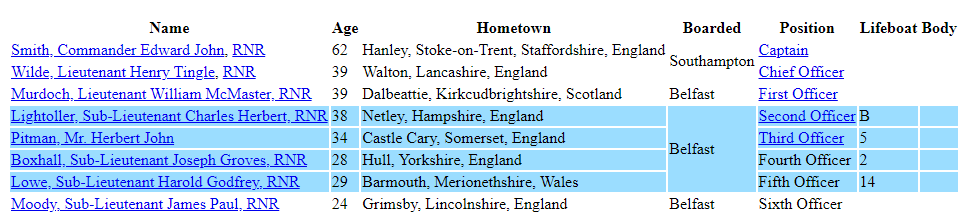

The `Postal clerks` table is missing the `Position` column, because the position of all these people was indeed "Postal clerk"; so, in this case, we'll only be interested in the first two columns and we'll add the same position manually for each of them. The Wikipedia page also says that none of these people survived, so we can set `SURVIVED = False` manually for all of them. `Age` never spans in this table, so we don't need to worry about that.

In [8]:
postal_clerks_table = tables[5]
postal_clerks_rows = postal_clerks_table.find_all("tr")[1:] # Skip the first row, because that's the header.
postal_clerks_dataframe = pd.DataFrame()

for i, row in enumerate(postal_clerks_rows):
    postal_clerks_cells = row.find_all("td", limit = 2) # Find only the first two <td>'s.
    postal_clerks_dataframe.loc[i, "NAME"] = postal_clerks_cells[0].get_text()
    postal_clerks_dataframe.loc[i, "AGE"] = postal_clerks_cells[1].get_text()
    
postal_clerks_dataframe["POSITION"] = "Postal clerk"
postal_clerks_dataframe["SURVIVED"] = False
postal_clerks_dataframe["GROUP"] = "Postal clerks"

The `Guarantee group` table contains these columns in this order:

- `Name`
- `Age`
- `Class` (according to Wikipedia, these people were given passenger accommodations despite being regarded as crew members.)
- `Hometown`
- `Boarded`
- `Position`

We're interested only in the first three and the last column. The table is so small that battling with rowspans simply isn't worth it; we're going to get names and ages like we did for the Postal cleks, and add the class and position to the dataframe entirely manually. Same goes for the survival status, as all these people died.

In [9]:
guarantee_group_table = tables[6]
guarantee_group_rows = guarantee_group_table.find_all("tr")[1:] # Skip the header.
guarantee_group_dataframe = pd.DataFrame()

for i, row, in enumerate(guarantee_group_rows):
    guarantee_group_cells = row.find_all("td", limit = 2) # Find only the first two <td>'s.
    guarantee_group_dataframe.loc[i, "NAME"] = guarantee_group_cells[0].get_text()
    guarantee_group_dataframe.loc[i, "AGE"] = guarantee_group_cells[1].get_text()    

# Copied straight out of the table, manually.
guarantee_class = ["First", "Second", "First", "Second", "Second", "Second", "Second", "First", "Second"]
guarantee_position = ["Shipbuilder", "Joiner", "Draughtsman", "Fitter", "Fitter", "Fitter", "Plumber", "Electrician", "Electrician's Apprentice"]

guarantee_group_dataframe["CLASS"] = guarantee_class
guarantee_group_dataframe["POSITION"] = guarantee_position
guarantee_group_dataframe["SURVIVED"] = False
guarantee_group_dataframe["GROUP"] = "Guarantee group"

Finally, the `Orchestra` table contains columns `Name`, `Age`, `Hometown`, `Position`, and `Body`, so we'll take only columns 1, 2, and 4. Again, we'll add position and survival status manually. (They all died.)

In [10]:
orchestra_table = tables[7]
orchestra_rows = orchestra_table.find_all("tr")[1:] # Skip the header.
orchestra_dataframe = pd.DataFrame()

for i, row, in enumerate(orchestra_rows):
    orchestra_cells = row.find_all("td", limit = 2) # Find only the first two <td>'s.
    orchestra_dataframe.loc[i, "NAME"] = orchestra_cells[0].get_text()
    orchestra_dataframe.loc[i, "AGE"] = orchestra_cells[1].get_text()
    
orchestra_positions = ["Pianist", "Cellist", "Bassist", "Bandmaster, violinist", "Violinist", "Violinist", "Cellist", "Cellist"]
    
orchestra_dataframe["SURVIVED"] = False
orchestra_dataframe["GROUP"] = "Orchestra" 
orchestra_dataframe["POSITION"] = orchestra_positions

Now that we have all the eight dataframes ready, we can join them into one.

In [11]:
dfs = ([officers_dataframe, deck_dataframe, engineering_dataframe, victualling_dataframe,
       restaurant_dataframe, postal_clerks_dataframe, guarantee_group_dataframe, orchestra_dataframe])

titanic_crew = pd.concat(dfs, axis = 0, ignore_index = True)
titanic_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NAME      866 non-null    object
 1   AGE       866 non-null    object
 2   POSITION  866 non-null    object
 3   SURVIVED  866 non-null    object
 4   GROUP     866 non-null    object
 5   CLASS     9 non-null      object
dtypes: object(6)
memory usage: 40.7+ KB


The resulting dataframe is missing the `SEX` column, which we're now going to add using a function that attempts to deduce the crew member's sex depending on any titles in their name.

In [12]:
def infer_sex(name):
    """Returns `Male` or `Female` depending on whether `name` contains titles such as
    'Mr.', 'Mrs.', etc. If none are found, returns 'Unknown'."""
    
    if ("Mr." in name) or ("Mr " in name): return "Male"    

    for title in ["Mrs.", "Mrs", "Miss"]:
        if title in name: return "Female"
    
    return "Unknown"

titanic_crew["SEX"] = titanic_crew["NAME"].map(infer_sex)
titanic_crew["SEX"].value_counts()

Male       822
Female      23
Unknown     21
Name: SEX, dtype: int64

### Cleaning the crew dataframe

Now that we have a unique crew dataframe, let's make sure there aren't any wrong or weird values in it. Let's start by double-checking that the sex assignment was correct, and see if we can assign the right sex to any `Unknown`s manually.

In [13]:
titanic_crew.query("SEX == 'Unknown'")

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX
0,"Smith, Commander Edward John, RNR",62,Captain,False,Officers,NaN,Unknown
1,"Wilde, Lieutenant Henry Tingle, RNR",39,Chief Officer,False,Officers,NaN,Unknown
2,"Murdoch, Lieutenant William McMaster, RNR",39,First Officer,False,Officers,NaN,Unknown
3,"Lightoller, Sub-Lieutenant Charles Herbert, RNR",38,Second Officer,True,Officers,NaN,Unknown
5,"Boxhall, Sub-Lieutenant Joseph Groves, RNR",28,Fourth Officer,True,Officers,NaN,Unknown
6,"Lowe, Sub-Lieutenant Harold Godfrey, RNR",29,Fifth Officer,True,Officers,NaN,Unknown
7,"Moody, Sub-Lieutenant James Paul, RNR",24,Sixth Officer,False,Officers,NaN,Unknown
48,"O'Loughlin, Dr. William Francis Norman",62,Surgeon,False,Deck,NaN,Unknown
58,"Simpson, Dr. John Edward",37,Assistant Surgeon,False,Deck,NaN,Unknown
179,"Gosling, S.",26,Trimmer,False,Engineering,NaN,Unknown


With the exception of `Gosling, S.` and `Instance, T.`, all names are obviously masculine. Their position reveal they were in the engineering department, which was overwhelmingly (if not entirely) male, so it's safe to assume they were too. (Additionally, Encyclopedia Titanica reports Instance, T. was male, although there is no Gosling, S. there.)

In [14]:
# Change all "Unknown" to "Male".
titanic_crew.loc[titanic_crew["SEX"] == "Unknown", "SEX"] = "Male"
titanic_crew["SEX"].value_counts()

Male      843
Female     23
Name: SEX, dtype: int64

Let's now check the crew members whom we guessed were female.

In [15]:
titanic_crew.query("SEX == 'Female'")

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX
420,"Bennett, Mrs. Mabel",30,First Class Stewardess,True,Victualling,NaN,Female
425,"Bliss, Mrs. Emma (née Junod)",45,First Class Stewardess,True,Victualling,NaN,Female
460,"Caton, Miss Annie",50,Turkish Bath Stewardess,True,Victualling,NaN,Female
533,"Gold, Mrs. Katherine (née Cook)",42,Stewardess,True,Victualling,NaN,Female
536,"Gregson, Miss Mary",44,Stewardess,True,Victualling,NaN,Female
585,"Jessop, Miss Violet Constance",24,Stewardess,True,Victualling,NaN,Female
613,"Lavington, Miss Bessie",39,Stewardess,True,Victualling,NaN,Female
616,"Leather, Mrs Elizabeth May",41,Stewardess,True,Victualling,NaN,Female
636,"Marsden, Miss Evelyn",28,Stewardess,True,Victualling,NaN,Female
637,"Martin, Mrs. Annie",33,Stewardess,True,Victualling,NaN,Female


The names of all people who have been assigned sex `Female` check out, and as it's reasonable to expect that most of the crew of ship would be male back in 1912, we can assume the rest of the assignments are correct too. Next, we should check that there aren't any obviously incorrect values in the columns `AGE`, `POSITION`, `SURVIVED`, and `CLASS.`

In [16]:
titanic_crew["AGE"].str.isdigit().value_counts()

True     861
False      5
Name: AGE, dtype: int64

Five ages can't be converted to integer, which means something is wrong with them. Let's see what they are.

In [17]:
titanic_crew.loc[titanic_crew["AGE"].str.isdigit() == False, :]

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX
252,"McCubbin, Mr. Lee",,Fireman/Stoker,False,Engineering,NaN,Male
320,"Saunders, Mr. Thomas",n/a,Fireman/Stoker,False,Engineering,NaN,Male
380,"Witt, Mr. F.",n/a,Trimmer,False,Engineering,NaN,Male
853,"Frost, Mr. Anthony Wood ""Artie""",37\n,Fitter,False,Guarantee group,Second,Male
854,"Knight, Mr. Robert J.",39\n,Fitter,False,Guarantee group,Second,Male


Upon inspecting the Wikipedia page, it seems clear that the first three ages are unknown and they don't seem to appear on Encyclopedia Titanica, so they can be set to `NaN`. The others had a newline character right after them for some reason, and it's enough to remove it.

In [18]:
from numpy import nan

titanic_crew.loc[252, "AGE"] = nan
titanic_crew.loc[320, "AGE"] = nan
titanic_crew.loc[380, "AGE"] = nan

titanic_crew.loc[853, "AGE"] = 37
titanic_crew.loc[854, "AGE"] = 39

titanic_crew["AGE"].str.isdigit().value_counts()

True    861
Name: AGE, dtype: int64

The reason why we still don't have 866 `True` values is that the five values we have corrected are no longer strings, so they can't be accessed through the `str` accessor. However, now we can turn the entire column to `float`, so the numbers should add up. (That is, we should have 863 non-null ages.)

In [19]:
titanic_crew["AGE"] = titanic_crew["AGE"].astype(float).round()
titanic_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NAME      866 non-null    object 
 1   AGE       863 non-null    float64
 2   POSITION  866 non-null    object 
 3   SURVIVED  866 non-null    object 
 4   GROUP     866 non-null    object 
 5   CLASS     9 non-null      object 
 6   SEX       866 non-null    object 
dtypes: float64(1), object(6)
memory usage: 47.5+ KB


Let's check the `POSITION` column. Since there are many positions with very few people occupying it, the list is long, and to see it all we need to change the maximum number of rows that Pandas will display.

In [20]:
pd.set_option("display.max_rows", None) # Set the maximum number of rows to `None`, so that we get to see them all.
titanic_crew["POSITION"].value_counts()

Fireman/Stoker                           158
Saloon Steward                            90
Trimmer                                   73
Steward                                   34
Greaser                                   34
Able Seaman                               32
Bedroom Steward                           30
First Class Saloon Steward                19
Asst. Waiter                              17
Waiter                                    15
Stewardess                                15
Scullion                                  13
Leading Fireman                           13
First Class Bedroom Steward               10
Assistant Saloon Steward                   9
Third Class Steward                        9
Mess Steward                               8
Plate Steward                              8
Quartermaster                              7
Lookout                                    6
Assistant Pantryman Steward                5
Second Class Saloon Steward                5
Postal cle

The only thing that looks weird is a blank role occupied by only one person. Let's see if we can find it.

In [22]:
titanic_crew.query("POSITION == ''")

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX
782,"Beux, Mr. David",26.0,,False,Restaurant,NaN,Male


From the Wikipedia page, it seems the role of Mr. Beux is unknown. (The `POSITION` cell is there, but it's empty.) However, _Encyclopedia Titanica_ [states](https://www.encyclopedia-titanica.org/titanic-victim/david-beux.html) he was an assistant waiter. Let's fix that. While we're at it, let's change all "Asst." to "Assistant" for uniformity's sake.

In [23]:
titanic_crew.at[782, "POSITION"] = "Assistant Waiter"
titanic_crew["POSITION"] = titanic_crew["POSITION"].str.replace("Asst.", "Assistant", regex = False)

The `SURVIVED` column should only contain `True` or `False`, and if it does, we can change it to `bool`.

In [24]:
titanic_crew["SURVIVED"].value_counts()

False    663
True     203
Name: SURVIVED, dtype: int64

In [25]:
titanic_crew["SURVIVED"] = titanic_crew["SURVIVED"].astype(bool)

The null values in the `CLASS` column can be changed to `Not applicable`, because the corresponding people had crew accommodations that didn't make a class distinction in the same way as passenger accommodations did.

In [26]:
titanic_crew["CLASS"].fillna("Not applicable", inplace = True)

To more easily distinguish crew from passengers, let's add an `AFFILIATION` column that contains `Crew` for crew members and `Passengers` otherwise.

In [27]:
titanic_crew["AFFILIATION"] = "Crew"

## Passengers

All we need to do here is some cleaning. Let's begin by loading and inspecting the passenger CSV dataset.

In [28]:
titanic_passengers = pd.read_csv("titanic_passengers.csv", header = 0)
titanic_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


The passengers dataset contains information about 1309 passengers; all the columns that we have in the `titanic_crew` dataframe are there, except `POSITION`, which in the case of passengers we'll fill with `Not applicable`. The columns `sibsp` and `parch` keep track of how many siblings or spouses and parents or children a passenger was travelling with; we won't be needing these columns for analysis purposes, but they might be be useful when we'll look for duplicates, so we'll keep them until then. This information isn't available for the crew, so for them this column will be all nulls. We will drop all the other columns now as we're not interested in them, and add the `GROUP` column that will say `Not applicable` for everyone and the `AFFILIATION` column that will say `Passengers`.

In [29]:
# Change the name of all columns we need to match the `titanic_crew` dataset.
titanic_passengers.rename(columns = {"pclass": "CLASS"}, inplace = True)
titanic_passengers.drop(columns = titanic_passengers.columns[7:], inplace = True) # From column 7 on, we don't need any of the columns.
titanic_passengers.rename(columns = lambda name : name.upper(), inplace = True)
titanic_passengers["POSITION"] = "Not applicable"
titanic_passengers["GROUP"] = "Not applicable"
titanic_passengers["AFFILIATION"] = "Passengers"
titanic_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CLASS        1309 non-null   int64 
 1   SURVIVED     1309 non-null   int64 
 2   NAME         1309 non-null   object
 3   SEX          1309 non-null   object
 4   AGE          1309 non-null   object
 5   SIBSP        1309 non-null   int64 
 6   PARCH        1309 non-null   int64 
 7   POSITION     1309 non-null   object
 8   GROUP        1309 non-null   object
 9   AFFILIATION  1309 non-null   object
dtypes: int64(4), object(6)
memory usage: 102.4+ KB


Before we can concatenate this dataframe with the crew dataframe, we'd bette' make sure that column values are consistent across the two. `CLASS` here is expressed in numbers, but we want it in text.

In [30]:
titanic_passengers["CLASS"].value_counts()

3    709
1    323
2    277
Name: CLASS, dtype: int64

We can quickly convert these values to text using the function below.

In [31]:
def class_to_string(c):
    """Accepts an integer representing a cabin class (1, 2, or 3) and returns a string 
    representation of the integer.
    `c` is an integer whose string representation is needed.
    """
    if c == 1: return "First"
    if c == 2: return "Second"
    if c == 3: return "Third"

titanic_passengers["CLASS"] = titanic_passengers["CLASS"].map(class_to_string).astype(str)

`SURVIVED` is supposed to be either `True` or `False` (or, in this case, `1` or `0`), and if it is, it can be turned into `bool`.

In [32]:
titanic_passengers["SURVIVED"].value_counts()

0    809
1    500
Name: SURVIVED, dtype: int64

In [33]:
titanic_passengers["SURVIVED"] = titanic_passengers["SURVIVED"].astype(bool)

The `SEX` column is already expressed in terms of `male` or `female`, we only need to capitalise them.

In [35]:
print(titanic_passengers["SEX"].value_counts())

Male      843
Female    466
Name: SEX, dtype: int64


In [36]:
titanic_passengers["SEX"] = titanic_passengers["SEX"].map(str.title)

The `AGE` column contains unknown values, but they're not nulls; they're expressed as question marks, and we need to change that. Some values are between zero and one, because they're the age of passengers who were infants at the time; others too may have non-zero decimals, but this information is not important, so we can round everything to the nearest integer, to match the `AGE` column in the crew dataframe.

In [250]:
titanic_passengers["AGE"].value_counts()

?         263
24         47
22         43
21         41
30         40
18         39
25         34
28         32
36         31
27         30
26         30
29         30
19         29
23         26
32         24
20         23
31         23
35         23
45         21
33         21
39         20
17         20
16         19
42         18
40         18
34         16
50         15
47         14
48         14
38         14
2          12
41         11
44         10
54         10
1          10
4          10
9          10
43          9
49          9
37          9
55          8
51          8
14          8
3           7
60          7
52          6
6           6
8           6
15          6
58          6
46          6
61          5
5           5
62          5
57          5
64          5
13          5
7           4
63          4
10          4
53          4
56          4
32.5        4
11          4
18.5        3
28.5        3
40.5        3
12          3
0.8333      3
65          3
0.75        3
59    

In [37]:
titanic_passengers["AGE"] = titanic_passengers["AGE"].map(lambda age: nan if age == "?" else age)
titanic_passengers["AGE"] = titanic_passengers["AGE"].astype(float).round()

Neither `SIBSP`, nor `PARCH` have nulls, but as they're going to for the crew, we should convert them to float.

In [38]:
titanic_passengers["SIBSP"] = titanic_passengers["SIBSP"].astype(float)
titanic_passengers["PARCH"] = titanic_passengers["PARCH"].astype(float)

## Concatenating the two datasets

The two datasets are now ready to be concatenated:

In [39]:
titanic = pd.concat([titanic_crew, titanic_passengers], ignore_index = True)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         2175 non-null   object 
 1   AGE          1909 non-null   float64
 2   POSITION     2175 non-null   object 
 3   SURVIVED     2175 non-null   bool   
 4   GROUP        2175 non-null   object 
 5   CLASS        2175 non-null   object 
 6   SEX          2175 non-null   object 
 7   AFFILIATION  2175 non-null   object 
 8   SIBSP        1309 non-null   float64
 9   PARCH        1309 non-null   float64
dtypes: bool(1), float64(3), object(6)
memory usage: 155.2+ KB


The data has already been cleaned before the dataset were merged, but there might well be duplicates. Let's check that.

In [40]:
duplicates = titanic.duplicated(keep = False) # Show each and every row that is identical to another.
duplicates.value_counts()

False    2175
dtype: int64

There are only no _fully_ identical rows, but there might be cases of duplicate names (homonymy) that turn out to be actually the same person with wrong data. We'll check this multiple times, so it's worth making a small function for it.

In [41]:
def show_homonyms():
    """Looks for people on board the Titanic with the same name and prints them out."""    
    homonym_indices = titanic.duplicated(subset = "NAME", keep = False)
    return titanic[homonym_indices].sort_values(by = "NAME")

show_homonyms()

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX,AFFILIATION,SIBSP,PARCH
78,"Barnes, Mr. Frederick",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
408,"Barnes, Mr. Frederick",37.0,Assistant Baker,False,Victualling,Not applicable,Male,Crew,NaN,NaN
423,"Blake, Mr. Seaton",26.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
97,"Blake, Mr. Seaton",26.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
936,"Chisholm, Mr. Roderick Robert Crispin",NaN,Not applicable,False,Not applicable,First,Male,Passengers,0.0,0.0
851,"Chisholm, Mr. Roderick Robert Crispin",40.0,Draughtsman,False,Guarantee group,First,Male,Crew,NaN,NaN
471,"Coleman, Mr. John",57.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
123,"Coleman, Mr. John",57.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
1592,"Connolly, Miss. Kate",30.0,Not applicable,False,Not applicable,Third,Female,Passengers,0.0,0.0
1591,"Connolly, Miss. Kate",22.0,Not applicable,True,Not applicable,Third,Female,Passengers,0.0,0.0


At least one person has an obvious duplicate—Mr August Louis Coutin. Wikipedia counted Mr Coutin as part of both victualling and restaurant, but according to _Encyclopedia Titanica_ there was only one person with this name and he was part of the Restaurant staff, so row `478` can go, again according to _Encyclopedia Titanica_, Mr. James Kelly wasn't some unlucky fellow how died no less than three times; rather, according to _Encyclopedia Titanic_ they were three different people, a crew member and two passengers. However, the age of one of them wasn't 34, but 19, so let's change that.

In [42]:
titanic.drop(index = 478, inplace = True)
titanic.loc[1790, "AGE"] = 19

Other cases are at least suspicious, namely `Chisholm, Mr. Roderick Robert Crispin`, `Cunningham, Mr. Alfred Fleming`, `Parr, Mr. William Henry Marsh`, and `Watson, Mr. Ennis Hastings`. The reason for that is that they were all part of the Guarantee group, which as said was comprised of crew members who were nonetheless given passenger accommodations. The copies that appear above all have the value `Passenger` in the `GROUP` column, so we know these names were part of the passenger dataset. For some reason, the age of duplicates varies sometimes dramatically, which gives us reason to suspect that many ages might be incorrect in our data. However, given the scope of this project, it's not worth wasting time looking for the exact age of each passenger; in a real-world setting, there are freemium resources that would definitely be worth checking excruciatingly thoroughly, such as the aforementioned _[Encyclopedia Titanica](https://www.encyclopedia-titanica.org/)_, but in our case, simply dropping the duplicates coming from the passenger dataset will suffice. (As a side note, the reason why I didn't scrape _Encyclopedia Titanica_ instead is that it has many separate lists on different pages, rather than just one as on Wikipedia.)

In [44]:
titanic.drop(index = [936, 1250, 1089, 1447], inplace = True)

Let's inspect the remaining homonyms to make sure there aren't other actual duplicates.

In [45]:
show_homonyms()

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX,AFFILIATION,SIBSP,PARCH
78,"Barnes, Mr. Frederick",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
408,"Barnes, Mr. Frederick",37.0,Assistant Baker,False,Victualling,Not applicable,Male,Crew,NaN,NaN
423,"Blake, Mr. Seaton",26.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
97,"Blake, Mr. Seaton",26.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
471,"Coleman, Mr. John",57.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
123,"Coleman, Mr. John",57.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
1592,"Connolly, Miss. Kate",30.0,Not applicable,False,Not applicable,Third,Female,Passengers,0.0,0.0
1591,"Connolly, Miss. Kate",22.0,Not applicable,True,Not applicable,Third,Female,Passengers,0.0,0.0
795,"Desvernine, Mr. Louis Gabriel",20.0,Assistant Pastry Cook,False,Restaurant,Not applicable,Male,Crew,NaN,NaN
498,"Desvernine, Mr. Louis Gabriel",20.0,Assistant Pastry Cook,False,Victualling,Not applicable,Male,Crew,NaN,NaN


According to Wikipedia, the two Mr. Barnes at the top are indeed different people with different hometowns. Browsing the free version of _Encyclopedia Titanica_, I was able to confirm that there were indeed two third-class passengers named Miss Connolly, except one was [Kate Connolly](https://www.encyclopedia-titanica.org/titanic-victim/kate-connolly-2.html), and the other was [Catherine Connolly](https://www.encyclopedia-titanica.org/titanic-survivor/kate-connolly.html). Both went by Kate, and only the latter survived. Let's update our data to avoid confusion. (Note that their ages on _Encyclopedia Titanica_ are slightly different, but for people born such a long time ago, figuring out the exact birth date can often be problematic and we don't want to mix up data from different sources without being sure of what we're doing, so we're not going to bother changing any age.)

In [46]:
titanic.at[1591, "NAME"] = "Connolly, Miss Catherine"
titanic.at[1592, "NAME"] = "Connolly, Miss Kate" # The original read "Miss." with a dot, which I don't think it makes sense, so let's remove it.

show_homonyms()

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX,AFFILIATION,SIBSP,PARCH
78,"Barnes, Mr. Frederick",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
408,"Barnes, Mr. Frederick",37.0,Assistant Baker,False,Victualling,Not applicable,Male,Crew,NaN,NaN
423,"Blake, Mr. Seaton",26.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
97,"Blake, Mr. Seaton",26.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
471,"Coleman, Mr. John",57.0,Mess Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
123,"Coleman, Mr. John",57.0,Mess Steward,False,Engineering,Not applicable,Male,Crew,NaN,NaN
498,"Desvernine, Mr. Louis Gabriel",20.0,Assistant Pastry Cook,False,Victualling,Not applicable,Male,Crew,NaN,NaN
795,"Desvernine, Mr. Louis Gabriel",20.0,Assistant Pastry Cook,False,Restaurant,Not applicable,Male,Crew,NaN,NaN
169,"Fraser, Mr. James",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
168,"Fraser, Mr. James",29.0,Junior Assistant Third Engineer,False,Engineering,Not applicable,Male,Crew,NaN,NaN


[It appears](https://www.encyclopedia-titanica.org/titanic-victim/seaton-blake.html) that Mr Seaton Blake was a mess steward in engineering, which is why he was counted twice. The same is true for [Mr. John Coleman](https://www.encyclopedia-titanica.org/titanic-victim/john-coleman.html). It makes sense to drop the Engineering copy. Just like Mr. Coutin above, Mr. Desvernine was counted both as part of victualling and restaurant, but _Encyclopedia Titanica_ [says](https://www.encyclopedia-titanica.org/titanic-victim/louis-gabriel-desvernine.html) he was in the Restaurant, so let's drop the other.

In [47]:
titanic.drop(index = [97, 123, 498], inplace = True)
show_homonyms()

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX,AFFILIATION,SIBSP,PARCH
78,"Barnes, Mr. Frederick",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
408,"Barnes, Mr. Frederick",37.0,Assistant Baker,False,Victualling,Not applicable,Male,Crew,NaN,NaN
168,"Fraser, Mr. James",29.0,Junior Assistant Third Engineer,False,Engineering,Not applicable,Male,Crew,NaN,NaN
169,"Fraser, Mr. James",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
190,"Harris, Mr. Edward",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
548,"Harris, Mr. Edward",18.0,Assistant Pantryman Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
221,"Kelly, Mr. James",44.0,Greaser,False,Engineering,Not applicable,Male,Crew,NaN,NaN
1790,"Kelly, Mr. James",19.0,Not applicable,False,Not applicable,Third,Male,Passengers,0.0,0.0
1791,"Kelly, Mr. James",44.0,Not applicable,False,Not applicable,Third,Male,Passengers,0.0,0.0
703,"Rice, Mr. John Reginald",25.0,Clerk,False,Victualling,Not applicable,Male,Crew,NaN,NaN


The two Mr Fraser were indeed separate people, although one of them is listed simply as "Mr J" on _Encyclopedia Titanica_. Similarly, both Mister Harris' were separate people. However, only one [Mr John Reginald Rice](https://www.encyclopedia-titanica.org/titanic-victim/john-reginald-rice.html) appears on _Encyclopedia Titanica_ and he was a clerk (so we'll drop the other row, `704`), while the two Mr Saunders were [William Henry](https://www.encyclopedia-titanica.org/titanic-victim/w-saunders.html) and [Walter Ernest](https://www.encyclopedia-titanica.org/titanic-victim/walter-ernest-saunders.html), respectively. Let's update our data again, including the slightly different ages.

In [48]:
titanic.drop(index = [1790, 704], inplace = True) # Drop the extra Mr Kelly and Mr Rice.

# Update the information on the two Mr Sanders.
titanic.at[321, "NAME"] = "Saunders, Mr. William Henry"
titanic.at[321, "AGE"] = 31

titanic.at[322, "NAME"] = "Saunders, Mr. Walter Ernest"
titanic.at[322, "AGE"] = 25

show_homonyms()

,NAME,AGE,POSITION,SURVIVED,GROUP,CLASS,SEX,AFFILIATION,SIBSP,PARCH
78,"Barnes, Mr. Frederick",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
408,"Barnes, Mr. Frederick",37.0,Assistant Baker,False,Victualling,Not applicable,Male,Crew,NaN,NaN
168,"Fraser, Mr. James",29.0,Junior Assistant Third Engineer,False,Engineering,Not applicable,Male,Crew,NaN,NaN
169,"Fraser, Mr. James",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
190,"Harris, Mr. Edward",29.0,Fireman/Stoker,False,Engineering,Not applicable,Male,Crew,NaN,NaN
548,"Harris, Mr. Edward",18.0,Assistant Pantryman Steward,False,Victualling,Not applicable,Male,Crew,NaN,NaN
221,"Kelly, Mr. James",44.0,Greaser,False,Engineering,Not applicable,Male,Crew,NaN,NaN
1791,"Kelly, Mr. James",44.0,Not applicable,False,Not applicable,Third,Male,Passengers,0.0,0.0


The only homonyms left are those we're sure are genuine, so we're done cleaning our dataset. We can export it as CSV so that we can analyse in a separate notebook. First, though, let's drop the columns `SIBSP` and `PARCH` (which turned out to be useless while checking the duplicates anyway) and rearrange the otehrs in a more sensible way.

In [49]:
titanic.drop(columns = ["SIBSP", "PARCH"], inplace = True)
new_column_order = ["NAME", "AGE", "SEX", "AFFILIATION", "GROUP", "POSITION", "CLASS", "SURVIVED"]
titanic = titanic.reindex (columns = new_column_order)
titanic.to_csv("titanic.csv", index = False)
titanic_test = pd.read_csv("titanic.csv")
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         2165 non-null   object 
 1   AGE          1903 non-null   float64
 2   SEX          2165 non-null   object 
 3   AFFILIATION  2165 non-null   object 
 4   GROUP        2165 non-null   object 
 5   POSITION     2165 non-null   object 
 6   CLASS        2165 non-null   object 
 7   SURVIVED     2165 non-null   bool   
dtypes: bool(1), float64(1), object(6)
memory usage: 120.6+ KB
